In [1]:
import paths
import yaml
import os
import copy
import h5py
import GPy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, collections as mc, patches as mpatches, cm, ticker, colors
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
from cklemap.sdfs.darcy import DarcyExp
from cklemap.sdfs.dasa import DASAExpKL, DASAExpKLAMPS
import cklemap.ckli.mapest as mapest
import cklemap.ckli.ba as ba
import drawSvg as draw

 /Users/yeun260/Library/Python/3.8/lib/python/site-packages/drawSvg/raster.py:18: RuntimeWarning:Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': dlopen(libcairo.so.2, 0x0002): tried: 'libcairo.so.2' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file, not in dyld cache), 'libcairo.so.2' (no such file), '/usr/local/lib/libcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file, not in dyld cache)
cannot load library 'libcairo.2.dylib': dlopen(libcairo.2.dylib, 0x0002): tried: 'libcairo.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibcairo.2.dylib' (no such file), '/usr/lib/libcairo.2.dylib' (no such file, not in dyld cache), 'libcairo.2.dylib' (n

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    #fig.colorbar(p, ax=ax)
    return p

In [3]:
amps = True
res_fac = 1
resolution = '1x'
resolution_iYobs = '1x'
num_trials = 1
trial_range = [0]
seed = 0
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nens = 5000
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
lsq_method = 'trf'
conditional = True
draw_field = False
draw_graph_pdf = False
data_path = '../data/'
results_path = '../results/'
figures_path = '../figures/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'yref/conduct_log_RF1_{resolution}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution_iYobs}.npy'
geom_fine_filename = data_path + f'geom/geom_{resolution_iYobs}.mat'
ref = "Yref=RF1"

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

with h5py.File(conduct_filename, 'r') as f:
    Yref = f.get('conduct_log')[:].ravel() - Yfac

In [5]:
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1

prob = DarcyExp(TPFA(geom, bc), iuobs, amps)
uref = prob.solve(Yref)

Nuobs = iuobs.size
uobs = uref[iuobs]

In [6]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

In [7]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref + Yfac, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [8]:
""" if os.path.exists(yobs_filename):
    print(f"iYobs read from file {yobs_filename}")
    iYobs_fine = np.load(yobs_filename)
    if iYobs_fine.shape[0] < num_trials:
        print("iYobs randomly generated")
        iYobs = rs.choice(Yref.size, NYobs, replace=False)
    geom_fine = GeomMRST(geom_fine_filename)
else:
    print("iYobs randomly generated")
    iYobs = rs.choice(Yref.size, NYobs, replace=False)
    np.save(yobs_filename, iYobs)

iYobs = np.array([geom.cellsContain(geom_fine.cells.centroids.T[iYobs_fine[t]]) for t in range(num_trials)]) """

if os.path.exists(yobs_filename):
    print(f"iYobs set read from file {yobs_filename}")
    iYobs = np.load(yobs_filename)
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False))
                     for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
# print(f"{iYobs.shape=}")
print(iYobs)

iYobs set read from file ../data/yobs/yobs_100_1x.npy
[[   4   14   31   34   52   53   54   82   89  122  141  142  148  152
   187  191  192  218  231  254  260  278  302  315  322  326  333  342
   347  361  362  364  376  408  420  427  431  434  438  446  458  465
   481  483  487  529  535  536  554  558  587  597  620  651  667  674
   737  758  761  838  847  853  857  863  884  897  900  930  942  961
  1001 1003 1030 1031 1054 1061 1069 1081 1095 1114 1122 1126 1131 1157
  1164 1175 1178 1187 1239 1270 1280 1285 1305 1338 1347 1352 1402 1438
  1444 1465]
 [  22   33   56   60   71   92  104  117  118  138  146  181  183  213
   216  227  246  248  276  302  306  311  329  333  336  352  378  388
   396  406  410  418  436  454  495  496  499  509  533  537  542  543
   545  547  548  600  611  615  641  643  648  668  673  678  681  692
   695  701  719  760  783  786  787  800  802  806  840  841  872  885
   906  918  933  954  961  965  968  998  999 1005 1009 1038 1083 10

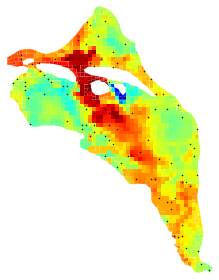

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_patch(patches, Yref + Yfac, fig, ax, geom.cells.centroids[:, iYobs[0]], 'Yref', 0, 12)
fig.tight_layout()
#fig.savefig(f'hanford/figures/Yref_NY={NYobs}_1x_from_4x.pdf', dpi=300)

In [10]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{NYxi=}_gamma={gamma_map}_{("cond" if conditional else "uncond")}_cklmap_h1reg_{amps=}_{ref}'
print(exp)

NY=100_Nu=323_NYlearn=100_NYxi=1000_gamma=1e-06_cond_cklmap_h1reg_amps=True_Yref=RF1


In [11]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
umean = np.zeros((num_trials, Nc))
Cu = np.zeros((num_trials, Nc, Nc))
upred = np.zeros((num_trials, Nc))
Cupred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))

Yest = np.zeros((num_trials, Nc))

In [12]:
""" for t in range(num_trials):
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s") """

for t in trial_range:
    iYlearn = iYobs[t]
    Ylearn = Yref[iYlearn]
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()

    mflearn = GPy.mappings.Constant(2, 1, value=1)
    klearn = GPy.kern.sde_Matern52(
        input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(
        geom.cells.centroids[:, iYlearn].T, Ylearn[:, None],
        klearn, noise_var=np.sqrt(np.finfo(float).eps),
        mean_function=mflearn)
    mYlearn.optimize(messages=True, ipython_notebook=False)

    if conditional:
        mYref = GPy.models.GPRegression(
            geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None],
            mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps),
            mean_function=mYlearn.constmap)
        Ypred[t], CYpred[t] = (lambda x, y: (x.ravel(), y))(
            *mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    else:
        Ypred[t] = mYlearn.constmap.C.values[0] * np.ones_like(Yref)
        CYpred[t] = mYlearn.kern.K(geom.cells.centroids.T)
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   3.743762e+03           nan 
    00s03  0005   1.836957e+02   3.551421e+03 
    00s06  0010   1.641540e+02   5.877629e+00 
    00s08  0013   1.636764e+02   3.506971e-03 
    00s10  0017   1.636762e+02   4.396709e-09 
Runtime:     00s10
Optimization status: Converged

GPR: [0.46224748] s


In [13]:
print(Yref)


[ 0.16545891 -0.14847811 -0.2268939  ...  1.87921178  2.33603422
  2.52019831]


In [14]:
print(Ypred[0])

[ 0.35102765  0.15573576 -0.17271289 ...  2.35674453  2.23340942
  2.24964022]


In [15]:
Ym = Ypred
CYm = CYpred

rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

print(f"GPR\tRelative error: {rel_errors[:, 0]}")
print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.13026042]
GPR	Infinity error: [4.71068738]


In [16]:
PsiY_all, LambdaY_all = ckliest.KL_via_eigh(CYm[0], Nc)
rtolY = LambdaY_all[NYxi:].sum() / LambdaY_all.sum()
print(f'{rtolY=}')


rtolY=0.0026198763909303377


In [17]:
for t in trial_range:
    ts = perf_counter()
    umean[t], Cu[t] = ckliest.smc_gp(Ypred[t], CYpred[t], Nens, prob, rs)
    upred[t], Cupred[t] = ckliest.gpr(umean[t], Cu[t], uobs, iuobs)
    timings[t, 1] = perf_counter() - ts

print(f"Monte Carlo: {timings[:, 1]} s")


Monte Carlo: [12.13480871] s


In [18]:
Nuxi = 1000
PsiY_all, LambdaY_all = ckliest.KL_via_eigh(CYm[0], Nc)
Psiu_all, Lambdau_all = ckliest.KL_via_eigh(Cu[0], Nc)
rtolu = Lambdau_all[Nuxi:].sum() / Lambdau_all.sum()
rtolY = LambdaY_all[NYxi:].sum() / LambdaY_all.sum()
print(f'{rtolu=}, {rtolY=}')

rtolu=4.287504895299396e-06, rtolY=0.0026198763909303377


In [19]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
    timings[t, 2] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [1.57216683] s


In [20]:
#BA = ba.BA(A1d_iuobs.T, u_pce_eta_arr, NYxi, uobs, gamma_map)

In [21]:
# CKL-MAP H1 estimate
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpKLAMPS(prob.partial_solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, prob.u_sens_p, (Nuobs + NYobs + Ninf, NYxi), Nuobs, Ym[t], PsiY[t])
    else:
        dasa = DASAExpKL(prob.solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u,
                         prob.residual_sens_Y, (Nuobs + NYobs + Ninf, NYxi), Nuobs, Ym[t], PsiY[t], prob.adj_solve)
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(NYxi), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest[t] = Ym[t] + PsiY[t] @ sol.x
    MAP_status = sol.status
    timings[t, 4] = perf_counter() - ts
    nfevs[t, 1] = sol.nfev
    print(f'CKL-MAP status: {MAP_status}, message: {sol.message}')

rel_errors[:, 2] = np.array([rl2e(Yest[t], Yref) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest[t], Yref) for t in range(num_trials)])

print(f"CKL-MAP: {timings[:, 4]} s")
print(f"CKL-MAP relative L2 error: {rel_errors[:, 2]}")
print(f"CKL-MAP absolute infinity error: {abs_errors[:, 2]}")


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8208e+02                                    8.41e+01    
       1              2         1.1356e+02      1.69e+02       1.00e+00       3.70e+01    
       2              3         1.5963e+01      9.76e+01       2.00e+00       5.86e+00    
       3              4         1.2846e+00      1.47e+01       4.00e+00       1.33e+00    
       4              5         1.8371e-01      1.10e+00       8.00e+00       9.06e-01    
       5              6         6.8102e-02      1.16e-01       1.60e+01       1.20e+00    
       6              8         3.1974e-03      6.49e-02       4.00e+00       1.75e-01    
       7             10         6.5739e-04      2.54e-03       2.00e+00       1.60e-02    
       8             12         6.0599e-04      5.14e-05       1.00e+00       9.97e-03    
       9             14         5.8840e-04      1.76e-05       5.00e-01       3.29e-03    

In [17]:
if draw_graph_pdf:
    plt.rcParams['lines.linewidth'] = 1
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(*geom.nodes.coords[:, geom.faces.nodes[:, geom.faces.num_interior:]], '#228b22')
    if prob.amps is not None and prob.amps.L is not None:
        centroids = geom.cells.centroids.T[prob.amps.P]
        ax.plot(*centroids[-1], '*-', c='gray', mfc='black', mec='none', ms='6', label='directed tree $G(L)$ and its root', zorder=2)
        first_nonclosure = False
        first_closure = False
        p = np.zeros((2, 2))
        for j in range(Nc-1):
            color = 'black' if np.all(prob.amps.closure_right_jac[j, (0, 20)]) else \
                    'red' if prob.amps.closure_right_jac[j, 0] else \
                    'blue' if prob.amps.closure_right_jac[j, 20] else 'gray'
            p[:, 0] = centroids[j]
            p[:, 1] = centroids[prob.amps.L.indices[prob.amps.L.indptr[j]+1]]
            line, = ax.plot(*p, color=color, zorder=1)
            if not first_closure and np.all(prob.amps.closure_right_jac[j, (0, 20)]):
                line.set_label('common closure')
                first_closure = True
            if not first_nonclosure and not np.any(prob.amps.closure_right_jac[j, (0, 20)]):
                #line.set_label('$G(L)$')
                ax.plot(
                    *centroids[np.flatnonzero(prob.amps.closure_right_jac[:, 0])[0]], 'ro-', ms='3', label='closure 1', zorder=2)
                ax.plot(
                    *centroids[np.flatnonzero(prob.amps.closure_right_jac[:, 20])[0]], 'bo-', ms='3', label='closure 2', zorder=2)
                first_nonclosure = True
    ax.set_aspect('equal')
    ax.axis('off')
    ax.legend(loc='lower left', frameon=False, prop={'size': 10})
    fig.tight_layout()
    figures_path = '../figures/'
    fig.savefig(figures_path +
                f'closure_{exp}.pdf', dpi=1200, bbox_inches='tight')


In [18]:
if draw_field:
    hex_colors = np.array([colors.to_hex(cm.get_cmap('jet')(colors.Normalize(0, 12)(Yref + Yfac))[t]) for t in range(Nc)])
    vertices = np.around(geom.nodes.coords.T[geom.cells.nodes.T, :], 4)

    d = draw.Drawing(1, 1)
    d.setRenderSize(1000, 1000)
    g = draw.Group(stroke_width=0.001, stroke='black')
    g.append(draw.Animate('fill-opacity', '4s', '0; 0; 1', keyTimes="0; 0.5; 1", fill='remove', id='seq_0'))
    g.append(draw.Animate('stroke-opacity', '2s', to='0', begin='2s', fill='freeze'))
    n, m = vertices.shape[:-1]
    v = np.empty((m + 1, m + 1), dtype=object)
    for j in range(n):
        p = draw.Path(fill=hex_colors[j]).M(*vertices[j, 0, :])
        v[:-1, 0] = np.repeat('M{},-{}'.format(*vertices[j, 0, :]), m)
        for i in range(1, m):
            p.L(*vertices[j, i, :])
            for k in range(i):
                v[k, i] = ' L{},-{}'.format(*vertices[j, k, :])
            for k in range(i, m):
                v[k, i] = ' L{},-{}'.format(*vertices[j, i, :])
        for k in range(m):
            v[k, m] = ' L{},-{}'.format(*vertices[j, k, :])
            v[m, k] = v[m - 1, k]
        v[m, m] = ' L{},-{}'.format(*vertices[j, 0, :])
        p.appendAnim(draw.Animate('d', '2s', ';\n'.join([''.join(r) for r in v]), fill='remove'))
        g.append(p.Z())
    d.append(g)

    #arrow_head = draw.Marker(-0.5, -0.5, 0.5, 0.5, scale=5, orient='auto')
    #arrow_head.append(draw.Lines(-0.5, -0.5, -0.5, 0.5, 0.5, 0, fill='blue', close=True))
    if prob.amps is not None and prob.amps.L is not None:
        centroids = np.around(geom.cells.centroids.T, 4)[prob.amps.P]
        obs_points = prob.amps.inz_left[prob.amps.P]
        g = draw.Group(stroke_width=0.001, fill='none')
        for j in range(Nc-1):
        #for j in range(prob.amps.new_to_old_left[1]+1):
            color = 'black' if prob.amps.closure_left[j] else 'gray'
            p1 = centroids[j]
            p2 = centroids[prob.amps.L.indices[prob.amps.L.indptr[j]+1]]
            l = draw.Line(*p1, *p2, stroke=color, stroke_opacity=0)
            l.appendAnim(draw.Animate('d', '0.1s', 'M{0},-{1} L{0},-{1};M{0},-{1} L{2},-{3}'.format(*p1, *p2), fill='remove', id=f'seq_{j+1}', begin='4s' if j == 0 else f'seq_{j}.end'))
            l.appendAnim(draw.Set('stroke-opacity', 'indefinite', to=1, begin='4s' if j == 0 else f'seq_{j}.end'))
            g.append(l)
            if obs_points[j]:
                c = draw.Circle(*centroids[j], 0.002, fill='black', opacity=0)
                c.appendAnim(draw.Set('opacity', 'indefinite', to=1, begin='4s' if j == 0 else f'seq_{j}.end'))
                g.append(c)
        d.append(g)
        d.append(draw.Circle(*centroids[-1], 0.002, fill='gray'))

    d.saveSvg(results_path + 'hanford.svg')

In [19]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest)